In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments
from transformers import pipeline
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
np.random.seed(0)
import warnings
warnings.filterwarnings('ignore')

In [2]:
model_id = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [3]:
trainset1 = load_dataset("ag_news", split="train[:60000]")
MAX_LENGTH = 256
trainset1 = trainset1.map(lambda e: tokenizer(e['text'], truncation=True, padding='max_length', max_length=MAX_LENGTH), batched=True)
trainset1.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask'])

samples = trainset1[np.random.choice(len(trainset1), 600, replace=False)]
input_ids = samples['input_ids'].cuda()
token_type_ids = samples['token_type_ids'].cuda()
attention_mask = samples['attention_mask'].cuda()

Using the latest cached version of the module from /home/dt/.cache/huggingface/modules/datasets_modules/datasets/ag_news/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548 (last modified on Tue Aug  3 16:53:03 2021) since it couldn't be found locally at /home/dt/SJTUProject/Inference/QuantitiveInference/ag_news/ag_news.py, or remotely (ConnectionError).
Using custom data configuration default
Reusing dataset ag_news (/home/dt/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)
Loading cached processed dataset at /home/dt/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548/cache-8fdfb607f0f0f36d.arrow


In [4]:

folder_list = ['int0.{}'.format(i) for i in range(10)] + ['int1.0', 'vic']
tinymodel_outputs = {}
minimodel_outputs = {}
smallmodel_outputs = {}
mediummodel_outputs = {}

In [5]:

with torch.no_grad():
    for folder_name in tqdm(folder_list):
        tinymodel_outputs[folder_name] = []
        for i in range(10):
            model = AutoModelForSequenceClassification.from_pretrained(
                "/data1/checkpoint/nlp/bert-tiny/{}/model_{}".format(folder_name, i))
            model.eval()
            model.cuda()
            tinymodel_outputs[folder_name].append(model(
                input_ids=input_ids, 
                        token_type_ids=token_type_ids, 
                        attention_mask=attention_mask).logits.softmax(dim=1).cpu())


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


In [6]:

with torch.no_grad():
    for folder_name in tqdm(folder_list[:-1]):
        minimodel_outputs[folder_name] = []
        for i in range(10):
            model = AutoModelForSequenceClassification.from_pretrained(
                "/data1/checkpoint/nlp/bert-mini/{}/model_{}/final".format(folder_name, i))
            model.eval()
            model.cuda()
            minimodel_outputs[folder_name].append(model(
                input_ids=input_ids, 
                        token_type_ids=token_type_ids, 
                        attention_mask=attention_mask).logits.softmax(dim=1).cpu())


100%|██████████| 11/11 [00:21<00:00,  1.91s/it]


In [7]:

with torch.no_grad():
    for folder_name in tqdm(folder_list[:-1]):
        smallmodel_outputs[folder_name] = []
        for i in range(10):
            model = AutoModelForSequenceClassification.from_pretrained(
                "/data1/checkpoint/nlp/bert-small/{}/model_{}/final".format(folder_name, i))
            model.eval()
            model.cuda()
            smallmodel_outputs[folder_name].append(model(
                input_ids=input_ids, 
                        token_type_ids=token_type_ids, 
                        attention_mask=attention_mask).logits.softmax(dim=1).cpu())


100%|██████████| 11/11 [00:49<00:00,  4.52s/it]


In [8]:

# with torch.no_grad():
#     for folder_name in tqdm(folder_list[:-1]):
#         mediummodel_outputs[folder_name] = []
#         for i in range(10):
#             model = AutoModelForSequenceClassification.from_pretrained(
#                 "/data1/checkpoint/nlp/bert-medium/{}/model_{}/final".format(folder_name, i))
#             model.eval()
#             model.cuda()
#             mediummodel_outputs[folder_name].append(model(
#                 input_ids=input_ids, 
#                         token_type_ids=token_type_ids, 
#                         attention_mask=attention_mask).logits.softmax(dim=1).cpu())


In [9]:
import pickle
pickle.dump(tinymodel_outputs, open("/home/dt/SJTUProject/Inference/results/nlp/tinymodel_outputs.pkl", "wb"))
pickle.dump(minimodel_outputs, open("/home/dt/SJTUProject/Inference/results/nlp/minimodel_outputs.pkl", "wb"))
pickle.dump(smallmodel_outputs, open("/home/dt/SJTUProject/Inference/results/nlp/smallmodel_outputs.pkl", "wb"))
# pickle.dump(mediummodel_outputs, open("/home/dt/SJTUProject/Inference/results/nlp/mediummodel_outputs.pkl", "wb"))



In [10]:
import pickle
tinymodel_outputs = pickle.load(open("/home/dt/SJTUProject/Inference/results/nlp/tinymodel_outputs.pkl", "rb"))
minimodel_outputs = pickle.load(open("/home/dt/SJTUProject/Inference/results/nlp/minimodel_outputs.pkl", "rb"))
smallmodel_outputs = pickle.load(open("/home/dt/SJTUProject/Inference/results/nlp/smallmodel_outputs.pkl", "rb"))
# mediummodel_outputs = pickle.load(open("/home/dt/SJTUProject/Inference/results/nlp/mediummodel_outputs.pkl", "rb"))


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [12]:
vic_mean = [v for v in tinymodel_outputs['vic']]
vic_mean = torch.stack(vic_mean).mean(dim=0)

df_dict = {'s': [], 'ModelID': [], 'Model Distance':[], 'Architecture':[]}

for folder in folder_list[:-1]:
    s = float(folder[-3:])
    for k, v in enumerate(tinymodel_outputs[folder]):
        diff = torch.sum((v - vic_mean)**2, dim=1).reshape(-1)
        df_dict['s'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Model Distance'].extend(diff.tolist())
        df_dict['Architecture'].extend(['Tiny-BERT'] * len(diff))
    for k, v in enumerate(minimodel_outputs[folder]):
        diff = torch.sum((v - vic_mean)**2, dim=1).reshape(-1)
        df_dict['s'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Model Distance'].extend(diff.tolist())
        df_dict['Architecture'].extend(['Mini-BERT'] * len(diff))

    for k, v in enumerate(smallmodel_outputs[folder]):
        diff = torch.sum((v - vic_mean)**2, dim=1).reshape(-1)
        df_dict['s'].extend([s] * len(diff))
        df_dict['ModelID'].extend([k] * len(diff))
        df_dict['Model Distance'].extend(diff.tolist())
        df_dict['Architecture'].extend(['Small-BERT'] * len(diff))

<AxesSubplot:xlabel='s', ylabel='Model Distance'>

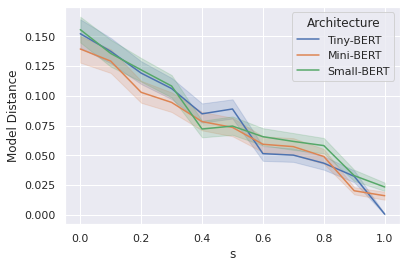

In [13]:
df_lineplot = pd.DataFrame.from_dict(df_dict)
sns.set_theme(style='darkgrid')
sns.lineplot(x='s', y='Model Distance', hue='Architecture', data=df_lineplot)

In [14]:
import scipy.stats as sps
from matplotlib.patches import Rectangle

In [15]:
inters = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
folder_list = ['int{}'.format(i) for i in inters] + ['vic']
same_stats_list = [ np.zeros((11, 11)) for _ in range(10)]
for i, folder_true in enumerate(folder_list[:-1]):
    int_mean = torch.stack(tinymodel_outputs[folder_true])
    dist_mean = torch.sum((int_mean - vic_mean.unsqueeze(0).expand(
            10, vic_mean.shape[0], vic_mean.shape[1]))**2, dim=2).mean(dim=0).cpu().numpy()
    for j, folder_test in enumerate(folder_list[:-1]):
        for k in range(10):
            int_test = tinymodel_outputs[folder_test][k]
            dist_test = torch.sum((int_test - vic_mean)**2, dim=1).cpu().numpy()
            stats, pv = sps.ttest_ind(dist_mean, dist_test)
            same_stats_list[k][j][i] = np.abs(stats)


In [16]:

heat_matrix = np.zeros((6, 6))
mini_stats_list = [ np.zeros((11, 11)) for _ in range(10)]
for i, folder_true in enumerate(folder_list[:-1]):
    print("-"*90)
    int_mean = torch.stack(tinymodel_outputs[folder_true])
    dist_mean = torch.sum((int_mean - vic_mean.unsqueeze(0).expand(
            10, vic_mean.shape[0], vic_mean.shape[1]))**2, dim=2).mean(dim=0).cpu().numpy()
    for j, folder_test in enumerate(folder_list[:-1]):
        
        
        statstmp= []
        for k in range(10):
            int_test = minimodel_outputs[folder_test][k]
            dist_test = torch.sum((int_test - vic_mean)**2, dim=1).cpu().numpy()
            
            stats, pv = sps.ttest_ind(dist_mean, dist_test)
            statstmp.append(np.abs(stats))
            mini_stats_list[k][j][i] = np.abs(stats)
            
        if i % 2 == 0 and j%2 == 0:
            ii = i//2
            jj = j//2
            stats = np.mean(statstmp)
            print(folder_true[-3:], folder_test[-3:], stats, pv)
            heat_matrix[jj][ii] = stats

------------------------------------------------------------------------------------------
0.0 0.0 0.5427032521747412 0.563097288856762
0.0 0.2 2.0828636376410423 0.03541808216335063
0.0 0.4 3.3283839280079603 0.0009392108350999695
0.0 0.6 4.330659186001045 1.354613196052303e-05
0.0 0.8 4.869421198478172 1.13543806711683e-06
0.0 1.0 7.059591815507804 3.2270434468583595e-12
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
0.2 0.0 0.8430995941047342 0.4459747587161522
0.2 0.2 0.7499526805839869 0.4399304151776352
0.2 0.4 2.0455444428445384 0.04245470441181335
0.2 0.6 3.132457079957702 0.0015442410769037963
0.2 0.8 3.728608611678035 0.0001833587538828742
0.2 1.0 6.20139744103592 8.848532292702532e-10
------------------------------------------------------------------------------------------
---------------------------------------------------------------------

In [17]:


small_stats_list = [ np.zeros((11, 11)) for _ in range(10)]
for i, folder_true in enumerate(folder_list[:-1]):
    int_mean = torch.stack(tinymodel_outputs[folder_true])
    dist_mean = torch.sum((int_mean - vic_mean.unsqueeze(0).expand(
            10, vic_mean.shape[0], vic_mean.shape[1]))**2, dim=2).mean(dim=0).cpu().numpy()
    for j, folder_test in enumerate(folder_list[:-1]):
        statstmp= []
        for k in range(10):
            int_test = smallmodel_outputs[folder_test][k]
            dist_test = torch.sum((int_test - vic_mean)**2, dim=1).cpu().numpy()
            
            stats, pv = sps.ttest_ind(dist_mean, dist_test)
            statstmp.append(np.abs(stats))
            small_stats_list[k][j][i] = np.abs(stats)


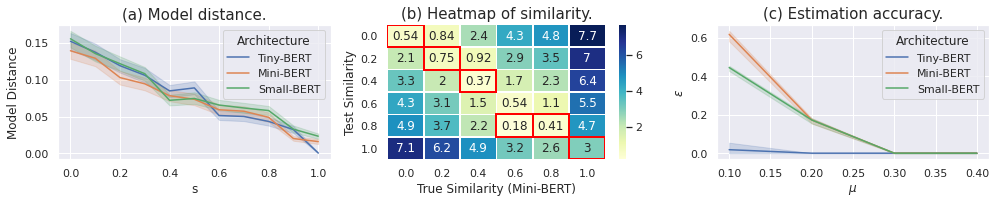

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(14, 3)
sns.set_theme(style='darkgrid')

sns.lineplot(x='s', y='Model Distance', hue='Architecture', data=df_lineplot, ax=ax1)

sns.heatmap(heat_matrix, #vmin=0, vmax=1, 
            cmap="YlGnBu", annot=True, 
            fmt='.2g', linewidths=.5, ax=ax2)
#             annot_kws={"fontsize":15})#, cbar=False, cbar_ax=None)
ax1.set_title("(a) Model distance.", fontsize=15)

ax2.set_xlabel("True Similarity (Mini-BERT)")
ax2.set_xticklabels(['0.0',  '0.2', '0.4','0.6', '0.8', '1.0'])#, fontsize=18)
ax2.set_yticklabels(['0.0',  '0.2', '0.4','0.6', '0.8', '1.0'], rotation=0)#, fontsize=18)
ax2.set_ylabel("Test Similarity")#, fontsize=20)
# use matplotlib.colorbar.Colorbar object
# cbar = ax1.collections[0].colorbar
# cbar.ax.tick_params(labelsize=18)
# cbar = ax1.collections[0].colorbar
# cbar.ax.tick_params(labelsize=18)
ax2.add_patch(Rectangle((5,5),1,1, fill=False, edgecolor='red', lw=2))
ax2.add_patch(Rectangle((4,4),1,1, fill=False, edgecolor='red', lw=2))
ax2.add_patch(Rectangle((3,4),1,1, fill=False, edgecolor='red', lw=2))
ax2.add_patch(Rectangle((2,2),1,1, fill=False, edgecolor='red', lw=2))
ax2.add_patch(Rectangle((1,1),1,1, fill=False, edgecolor='red', lw=2))
ax2.add_patch(Rectangle((0,0),1,1, fill=False, edgecolor='red', lw=2))
ax2.set_title("(b) Heatmap of similarity.", fontsize=15)



sns.lineplot(x='Mu', y='Eps', data=approx_df, hue='Architecture', ax=ax3)
ax3.set_xlabel("$\mu$")
ax3.set_ylabel("$\epsilon$")
ax3.set_title("(c) Estimation accuracy.", fontsize=15)
plt.tight_layout()
plt.savefig('figures/nlp_result.pdf', bbox_inches='tight')
plt.show()

In [22]:
approx_dfdict = {'ModelID':[], 'Mu':[], 'Eps':[], 'Architecture':[]}
for k in range(10):
    print(same_stats_list[k], same_stats_list[k].argmin(axis=0))
    dist = np.abs(same_stats_list[k].argmin(axis=0) - np.arange(0, 11))
    print(dist)
    print('8'*10)
    for m in range(1, 5, 1):
        approx_dfdict['Mu'].append(m/10)
        approx_dfdict['Eps'].append((dist>=m).astype(np.int32).mean())
        approx_dfdict['ModelID'].append(k)
        approx_dfdict['Architecture'].append('Tiny-BERT')

for k in range(10):
    print(mini_stats_list[k], mini_stats_list[k].argmin(axis=0))
    dist = np.abs(mini_stats_list[k].argmin(axis=0) - np.arange(0, 11))
    print(dist)
    print('8'*10)
    for m in range(1, 5, 1):
        approx_dfdict['Mu'].append(m/10)
        approx_dfdict['Eps'].append((dist>=m).astype(np.int32).mean())
        approx_dfdict['ModelID'].append(k)
        approx_dfdict['Architecture'].append('Mini-BERT')
for k in range(10):
    print(small_stats_list[k], small_stats_list[k].argmin(axis=0))
    dist = np.abs(small_stats_list[k].argmin(axis=0) - np.arange(0, 11))
    print(dist)
    print('8'*10)
    for m in range(1, 5, 1):
        approx_dfdict['Mu'].append(m/10)
        approx_dfdict['Eps'].append((dist>=m).astype(np.int32).mean())
        approx_dfdict['ModelID'].append(k)
        approx_dfdict['Architecture'].append('Small-BERT')
                
approx_df = pd.DataFrame.from_dict(approx_dfdict)

[[0.04971922 0.52518257 1.30102284 1.86931085 2.89710402 2.69084452
  4.71697023 4.76144415 5.18391347 5.83537277 8.04638637]
 [0.51299665 0.0700533  0.85294359 1.43585022 2.49163027 2.27904277
  4.38749636 4.43466713 4.87946463 5.56923948 7.94750503]
 [1.24701609 0.66225526 0.11257843 0.70564828 1.77738807 1.5607942
  3.73781795 3.78941699 4.25463489 4.98503171 7.55123101]
 [1.66799759 1.0885981  0.32910511 0.26180029 1.3249049  1.10987753
  3.28353304 3.33766177 3.80336532 4.54109294 7.1448679 ]
 [3.18355929 2.61305674 1.89934406 1.29846524 0.23132179 0.44881873
  1.82934175 1.8966595  2.40033166 3.23013984 6.33221377]
 [3.46993033 2.90449921 2.20585511 1.60737243 0.54970678 0.76542675
  1.50841762 1.57861553 2.08311507 2.92240941 6.08832837]
 [4.55375332 4.00837595 3.37357639 2.78353701 1.76442426 1.97295882
  0.29395093 0.37823864 0.89126587 1.78540767 5.35982966]
 [4.60564322 4.06355874 3.4346647  2.84884057 1.83976445 2.04605599
  0.19340777 0.27776278 0.78225582 1.66327828 5.154